# Player Career Trajectory Clustering using ATP Elo Data (Unsupervised ML)

In this notebook, we perform an **unsupervised machine learning analysis** on ATP tennis players using Elo-based career statistics.

Instead of focusing on individual matches, we take a **player-centric, career-level view**:

- For each **player and season (year)**, we compute:
  - Matches played
  - Wins and win percentage
  - Average Elo
  - Peak Elo in that year
- We then aggregate these into **career summary features** for each player:
  - Career peak Elo and average Elo  
  - Total matches and overall career win percentage  
  - Career length (number of active seasons)  
  - Early-career win% vs late-career win%  
  - Change in win% from early to late career

Using these features, we apply **unsupervised learning**:

- **Standardization** of features so Elo values, counts, and percentages are on a comparable scale.
- **K-Means clustering** to group players with similar career profiles.
- **t-SNE** (t-Distributed Stochastic Neighbor Embedding) to project players into 2D space for visualization, coloring each point by its cluster.

This lets us discover natural groups such as:

- Elite long-term high performers  
- Strong but less dominant tour regulars  
- Lower-ranked or struggling players  

and interpret how different **career profiles** emerge from Elo-based data, without ever providing the algorithm explicit labels.


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Load match-level Elo dataset
# ---------------------------------------------------------

BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / "Data" / "ML_final.csv"

print("Working dir :", BASE_DIR)
print("Reading file:", DATA_PATH)

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}. "
        f"Run create_ml_dataset.py or check the filename."
    )

df = pd.read_csv(DATA_PATH)
print("Raw rows:", len(df))


Working dir : /Users/meghananataraju/Documents/Fall2025/CS418/Tennis_ATP
Reading file: /Users/meghananataraju/Documents/Fall2025/CS418/Tennis_ATP/Data/ML_final.csv
Raw rows: 58502


Extract season (year) from match date

We convert the `tourney_date` column to a proper datetime type and then extract the **year** into a new `year` column.

This allows us to group matches by **season** (year) for each player and compute per-season statistics like:

- Matches played in that year
- Wins in that year
- Average & peak Elo in that year

In [5]:
# ---------------------------------------------------------
# 2. Parse date -> year
# ---------------------------------------------------------

df["tourney_date"] = pd.to_datetime(df["tourney_date"], errors="coerce")
df["year"] = df["tourney_date"].dt.year
df = df.dropna(subset=["year"]).copy()
df["year"] = df["year"].astype(int)

print("Rows with valid year:", len(df))

required_cols = [
    "winner_name", "loser_name",
    "winner_elo", "loser_elo",
    "surface"
]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"Required column '{c}' not found in ML_final.csv")

print("Columns OK for trajectory clustering.")



Rows with valid year: 58502
Columns OK for trajectory clustering.


Build a per-player-per-match table (winner + loser rows)

The raw match data has separate columns for winners and losers.  
To analyze players uniformly, we convert this into a **long format** where:

- Each row represents a **player in a specific match**
- Columns:
  - `player` — player name
  - `year` — season
  - `surface` — court type
  - `elo` — that player’s Elo before/at the match
  - `is_win` — 1 if this row is the winner, 0 if loser

We do this by creating **two rows per match**:

- one for the winner (`is_win = 1`)
- one for the loser (`is_win = 0`)

This gives us a clean “player-centric” view of the data.

In [6]:

# ---------------------------------------------------------
# 3. Build per-player-per-match long table
# ---------------------------------------------------------

rows = []

for _, row in df.iterrows():
    rows.append({
        "player": row["winner_name"],
        "year": row["year"],
        "surface": row["surface"],
        "elo": row["winner_elo"],
        "is_win": 1,
    })
    rows.append({
        "player": row["loser_name"],
        "year": row["year"],
        "surface": row["surface"],
        "elo": row["loser_elo"],
        "is_win": 0,
    })

long_df = pd.DataFrame(rows)
long_df = long_df.dropna(subset=["player", "year"]).copy()

print("Per-player-per-match rows:", len(long_df))
print(long_df.head())



Per-player-per-match rows: 117004
           player  year surface          elo  is_win
0  Lleyton Hewitt  1970    Hard  1992.662425       1
1  Arnaud Clement  1970    Hard  1649.161228       0
2   Roger Federer  1970    Hard  2106.362846       1
3    David Ferrer  1970    Hard  1625.433480       0
4     Carlos Moya  1970    Hard  1885.790021       1


Compute per-player-per-year (season) statistics

Using the long per-match table, we group by `player` and `year` to compute **season-level stats**:

- `matches_played` — total matches played in that year
- `wins` — number of wins in that year
- `avg_elo` — average Elo across that year’s matches
- `peak_elo` — maximum Elo in that year
- `win_pct` — win percentage = wins / matches_played

This gives us a time series for each player: how their performance looked year by year.


In [7]:

# ---------------------------------------------------------
# 4. Per-player-per-year (season) stats
# ---------------------------------------------------------

yearly_stats = (
    long_df
    .groupby(["player", "year"], as_index=False)
    .agg(
        matches_played=("is_win", "count"),
        wins=("is_win", "sum"),
        avg_elo=("elo", "mean"),
        peak_elo=("elo", "max"),
    )
)

yearly_stats["win_pct"] = yearly_stats["wins"] / yearly_stats["matches_played"]

print("\nSample yearly stats:")
print(yearly_stats.head())




Sample yearly stats:
                    player  year  matches_played  wins      avg_elo  \
0  Abd Hazli Bin Zainuddin  1970               4     1  1422.732124   
1     Abdelhak Hameurlaine  1970               5     1  1346.818177   
2     Abdul Mumin Babalola  1970               3     0  1443.716657   
3     Abdulhameed Alshatti  1970               2     0  1463.797033   
4       Abdulhamid Mubarak  1970               1     0  1500.000000   

      peak_elo  win_pct  
0  1500.000000     0.25  
1  1379.399635     0.20  
2  1500.000000     0.00  
3  1500.000000     0.00  
4  1500.000000     0.00  


Summarize each player’s career (including early vs late form)

For each player, we now aggregate over all their seasons to build **career-level features**:

- `career_peak_elo` — highest Elo across the career
- `career_avg_elo` — average of yearly `avg_elo`
- `career_matches` — total matches played
- `career_win_pct` — total wins ÷ total matches
- `career_length_years` — number of distinct seasons

We also split the career into:

- **Early career** — first up to 3 seasons
- **Late career** — last up to 3 seasons

and compute:

- `early_win_pct` — win% in early seasons
- `late_win_pct` — win% in late seasons
- `win_pct_change` = `late_win_pct − early_win_pct`  
  (positive → improved over time, negative → declined over time)

These features are what we’ll use to cluster players by their overall career profile and (in principle) by their trajectory.

In [8]:

# ---------------------------------------------------------
# 5. Career-level summary + early vs late form
# ---------------------------------------------------------

def summarize_player_career(player_group: pd.DataFrame) -> pd.Series:
    player_group = player_group.sort_values("year")
    years = player_group["year"].unique()
    n_years = len(years)

    total_matches = player_group["matches_played"].sum()
    total_wins = player_group["wins"].sum()
    career_win_pct = total_wins / total_matches if total_matches > 0 else np.nan

    career_peak_elo = player_group["peak_elo"].max()
    career_avg_elo = player_group["avg_elo"].mean()
    career_length_years = n_years

    early_years = years[: min(3, n_years)]
    late_years = years[-min(3, n_years):]

    early = player_group[player_group["year"].isin(early_years)]
    late = player_group[player_group["year"].isin(late_years)]

    early_matches = early["matches_played"].sum()
    early_wins = early["wins"].sum()
    late_matches = late["matches_played"].sum()
    late_wins = late["wins"].sum()

    early_win_pct = early_wins / early_matches if early_matches > 0 else np.nan
    late_win_pct = late_wins / late_matches if late_matches > 0 else np.nan

    if not np.isnan(early_win_pct) and not np.isnan(late_win_pct):
        win_pct_change = late_win_pct - early_win_pct
    else:
        win_pct_change = np.nan

    return pd.Series({
        "career_peak_elo": career_peak_elo,
        "career_avg_elo": career_avg_elo,
        "career_matches": total_matches,
        "career_win_pct": career_win_pct,
        "career_length_years": career_length_years,
        "early_win_pct": early_win_pct,
        "late_win_pct": late_win_pct,
        "win_pct_change": win_pct_change,
    })


career_df = (
    yearly_stats
    .groupby("player")
    .apply(summarize_player_career)
    .reset_index()
)

print("\nCareer-level stats (sample):")
print(career_df.head())




Career-level stats (sample):
                    player  career_peak_elo  career_avg_elo  career_matches  \
0  Abd Hazli Bin Zainuddin      1500.000000     1422.732124             4.0   
1     Abdelhak Hameurlaine      1379.399635     1346.818177             5.0   
2     Abdul Mumin Babalola      1500.000000     1443.716657             3.0   
3     Abdulhameed Alshatti      1500.000000     1463.797033             2.0   
4       Abdulhamid Mubarak      1500.000000     1500.000000             1.0   

   career_win_pct  career_length_years  early_win_pct  late_win_pct  \
0            0.25                  1.0           0.25          0.25   
1            0.20                  1.0           0.20          0.20   
2            0.00                  1.0           0.00          0.00   
3            0.00                  1.0           0.00          0.00   
4            0.00                  1.0           0.00          0.00   

   win_pct_change  
0             0.0  
1             0.0  
2       

/var/folders/dm/8mhjf_8s0g1c4zj1xgxhgkh40000gn/T/ipykernel_806/2853572127.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_player_career)


Filter to players with sufficient career data

Not all players have enough matches to give a meaningful career profile.  
We keep only players with at least a chosen minimum number of matches:

- `MIN_MATCHES` (e.g., 80)

Then we drop players who are missing any of the key features.  
This leaves us with a set of players whose careers are substantial enough to compare and cluster.

In [9]:

# ---------------------------------------------------------
# 6. Filter to players with enough data
# ---------------------------------------------------------

MIN_MATCHES = 80  # change if you want
career_df_filtered = career_df[career_df["career_matches"] >= MIN_MATCHES].copy()

features_for_clustering = [
    "career_peak_elo",
    "career_avg_elo",
    "career_matches",
    "career_win_pct",
    "career_length_years",
    "early_win_pct",
    "late_win_pct",
    "win_pct_change",
]

career_df_filtered = career_df_filtered.dropna(subset=features_for_clustering)

print("\nPlayers kept for clustering:", len(career_df_filtered))




Players kept for clustering: 345


Standardize features and run K-Means clustering

We take the career-level features:

- `career_peak_elo`
- `career_avg_elo`
- `career_matches`
- `career_win_pct`
- `career_length_years`
- `early_win_pct`
- `late_win_pct`
- `win_pct_change`

and put them into a feature matrix `X`.

Since these features have different scales (Elo vs percentages vs counts), we:

1. **Standardize** them using `StandardScaler`  
   → each feature has mean 0 and variance 1.

2. Run **K-Means** clustering with `k = 3` clusters  
   → the algorithm groups players whose career profiles are similar in this feature space.

The result: each player is assigned to a cluster ID (0, 1, or 2).

In [10]:

# ---------------------------------------------------------
# 7. Standardize features + K-Means
# ---------------------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = career_df_filtered[features_for_clustering].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

career_df_filtered["cluster"] = cluster_labels

print("\nCluster sizes:")
print(career_df_filtered["cluster"].value_counts().sort_index())




Cluster sizes:
cluster
0    145
1     56
2    144
Name: count, dtype: int64


Compute a 2D t-SNE embedding for visualization

The clustering happens in an 8-dimensional feature space, which is hard to visualize directly.

To create an interpretable 2D picture, we:

- Apply **t-SNE** (t-Distributed Stochastic Neighbor Embedding) to the standardized features.
- This maps each player to coordinates (`tsne_x`, `tsne_y`) in 2D, trying to preserve local neighborhood structure.

We don’t use t-SNE for training the clusters — it’s only for **visualizing** how the clustered players are arranged in a 2D plane.

In [11]:

# ---------------------------------------------------------
# 8. t-SNE embedding for visualization
# ---------------------------------------------------------

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    init="pca",
    learning_rate="auto",
)

X_embedded = tsne.fit_transform(X_scaled)
career_df_filtered["tsne_x"] = X_embedded[:, 0]
career_df_filtered["tsne_y"] = X_embedded[:, 1]

print("\nSample of clustered players:")
print(
    career_df_filtered[
        ["player",
         "career_peak_elo", "career_win_pct",
         "career_matches", "career_length_years",
         "early_win_pct", "late_win_pct", "win_pct_change",
         "cluster", "tsne_x", "tsne_y"]
    ].head()
)




Sample of clustered players:
              player  career_peak_elo  career_win_pct  career_matches  \
26  Adrian Mannarino      1811.542605        0.469136           648.0   
31   Agustin Calleri      1790.604951        0.507463           201.0   
45   Albert Montanes      1785.736762        0.482517           429.0   
47      Albert Ramos      1766.700961        0.460033           613.0   
51    Alberto Martin      1711.113212        0.400000           155.0   

    career_length_years  early_win_pct  late_win_pct  win_pct_change  cluster  \
26                  1.0       0.469136      0.469136             0.0        2   
31                  1.0       0.507463      0.507463             0.0        2   
45                  1.0       0.482517      0.482517             0.0        2   
47                  1.0       0.460033      0.460033             0.0        2   
51                  1.0       0.400000      0.400000             0.0        0   

       tsne_x    tsne_y  
26   8.166162  5.8

Plot clustered players in 2D (t-SNE scatter plot)

Using the t-SNE coordinates (`tsne_x`, `tsne_y`) and the cluster labels, we create a scatter plot where:

- Each point represents a **player**.
- Position is given by the t-SNE coordinates.
- Color indicates the **cluster** (0, 1, or 2).

This plot gives an intuitive view of how different types of careers group together and how distinct the clusters are from one another.

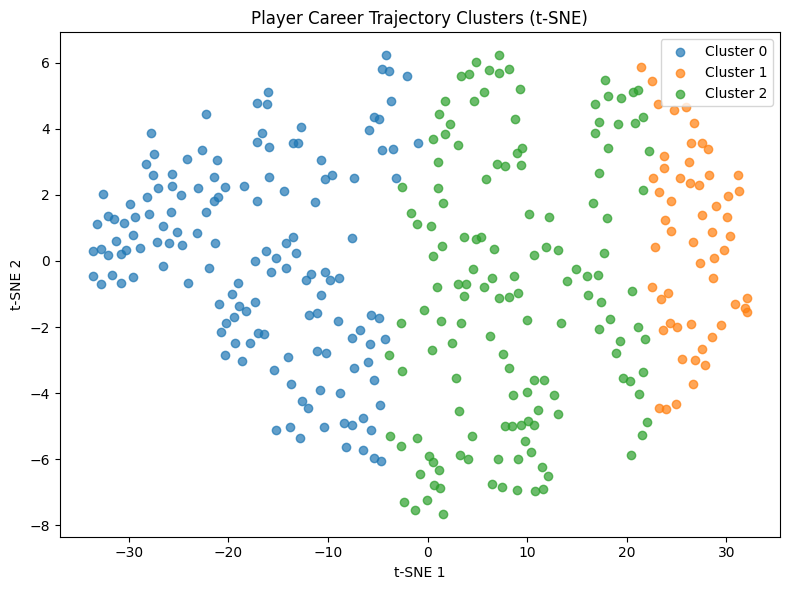

In [12]:

# ---------------------------------------------------------
# 9. Scatter plot of clusters
# ---------------------------------------------------------

plt.figure(figsize=(8, 6))
for c in range(k):
    subset = career_df_filtered[career_df_filtered["cluster"] == c]
    plt.scatter(subset["tsne_x"], subset["tsne_y"], alpha=0.7, label=f"Cluster {c}")

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Player Career Trajectory Clusters (t-SNE)")
plt.legend()
plt.tight_layout()
plt.show()



Summarize and interpret the clusters

Finally, we:

1. Compute **cluster-wise averages** of the career features  
   (e.g., average peak Elo, matches, win%, early/late win%).

2. Print **sample players** from each cluster (typically those with the highest peak Elo in that cluster).

From these summaries, we can interpret each cluster in human terms, for example:

- Cluster 1: high peak Elo, high win%, many matches  
  → “elite, long-term top performers”
- Cluster 2: mid-to-high Elo, ~50% win rate, solid career length  
  → “strong tour regulars”
- Cluster 0: lower Elo, lower win%  
  → “lower-tier / journeyman players”

These interpretations turn the raw clusters into meaningful labels we can describe in a report or presentation.

In [13]:

# ---------------------------------------------------------
# 10. Cluster summaries
# ---------------------------------------------------------

cluster_summary = (
    career_df_filtered
    .groupby("cluster")[features_for_clustering]
    .mean()
    .round(3)
)

print("\nCluster-wise average features:\n")
print(cluster_summary)

print("\nCluster sizes:")
print(career_df_filtered["cluster"].value_counts().sort_index())

cols_show = [
    "player",
    "career_peak_elo",
    "career_avg_elo",
    "career_matches",
    "career_win_pct",
    "career_length_years",
    "early_win_pct",
    "late_win_pct",
    "win_pct_change",
    "cluster",
]

for c in sorted(career_df_filtered["cluster"].unique()):
    print(f"\n=== Cluster {c}: sample players (sorted by career_peak_elo) ===")
    sample = (
        career_df_filtered[career_df_filtered["cluster"] == c]
        .sort_values("career_peak_elo", ascending=False)
        .head(10)[cols_show]
    )
    print(sample.to_string(index=False))



Cluster-wise average features:

         career_peak_elo  career_avg_elo  career_matches  career_win_pct  \
cluster                                                                    
0               1662.892        1554.194         151.400           0.379   
1               1989.278        1835.834         593.500           0.646   
2               1797.031        1668.620         311.104           0.495   

         career_length_years  early_win_pct  late_win_pct  win_pct_change  
cluster                                                                    
0                        1.0          0.379         0.379             0.0  
1                        1.0          0.646         0.646             0.0  
2                        1.0          0.495         0.495             0.0  

Cluster sizes:
cluster
0    145
1     56
2    144
Name: count, dtype: int64

=== Cluster 0: sample players (sorted by career_peak_elo) ===
             player  career_peak_elo  career_avg_elo  career_match